In [1]:
!nvidia-smi

Wed Jul 31 15:19:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W / 250W |      0MiB / 16280MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

import DataGenerator as DG
from DataGenerator import DataGenerator

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from keras_contrib.layers import crf
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
#Progress bar fix: use callbacks=[Logger.JupyterProgbarLogger()] in fit method
#verbose=0 is also required
import JupyterProgbarLogger as Logger
from tqdm import tqdm_notebook as tqdm
from kerastuner.tuners import RandomSearch


import sklearn.metrics as metrics

import numpy as np
import random
import math

from datetime import datetime
import os.path
from shutil import copy
from functools import partial

import matplotlib.pyplot as plt

import h5py

###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [2]:
#Data Variables
BATCH_SIZE=8
DATA_AMOUNT=400000
VALIDATION_AMOUNT=1000
OFFSET_AMOUNT=100000#690000
#frames per sample / 3rd dimension for 3D CNN
depth=10
filepath = "images_synthetic_mouse.h5"
scratch_dir = ""#"/n/scratch2/ap487/"

USE_TUNER = False
USE_CRF = False

In [3]:
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  images_synthetic_mouse.h5


In [4]:
def build_model(tuner,
                input_shape=(80, 80, 1),
                stride_length=(1, 1),
                kernel=(3,3),
                kernel_initializer='glorot_uniform',
                activation=layers.Activation('relu'),
                dense_activation=layers.Activation('relu'),
                output_activation=layers.Activation('softmax'),
                batch_momentum=.999,
                dropout_chance=0.2,
                combine=True,
                padding='same',
                batch_norm=False,
                dropout=False
            ):
    name = "LSTM CNN"
    if depth > 1:
        input_shape = (depth,)+input_shape
    inputs = layers.Input(shape=input_shape)
    x = inputs
    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer
    }
    # encode net
    x = layers.TimeDistributed(layers.Conv2D(16, kernel, **conv_parameters),input_shape=input_shape)(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Conv2D(32, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.Conv2D(32, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    #x = layers.Bidirectional(layers.LSTM(512))(x)
    #x = layers.LSTM(512)(x)
    if USE_CRF:
        x = layers.LSTM(512,return_sequences=True)(x)
        output = crf.CRF(64)(x)
    else:
        x = layers.LSTM(512,return_sequences=False)(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(64, activation='relu')(x)
        output = output_activation(x)
    model = keras.models.Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=1e-4,
            momentum=.9,
            nesterov=True,
            decay=1e-6
        ),
        loss='sparse_categorical_crossentropy',#crf_loss,
        metrics=['accuracy']
    )
    return model,name

In [5]:
if not depth == 1:
    if USE_TUNER:
        tuner = RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=40,
            executions_per_trial=1,
            directory='actionrecog',
            project_name='Action Recognition',
            is_generator=True)
        print(tuner.search_space_summary())
    else:
        model,name = build_model(None,input_shape=(80,80,1))
        model.summary()
else:
    model,name = build_model()
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 80, 80, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 80, 80, 16)    160       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 40, 40, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 40, 40, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 20, 20, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 20, 20, 64)    18496 

In [6]:
#Initialize generators
data_gen = DataGenerator(filepath,data_amount=DATA_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=OFFSET_AMOUNT,sliding_window=5)
validation_gen = DataGenerator(filepath,data_amount=VALIDATION_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=DATA_AMOUNT+OFFSET_AMOUNT,sliding_window=5)

In [ ]:
if USE_TUNER:
    tuner.search(generator=data_gen, validation_data=validation_gen,
                use_multiprocessing=True, workers=10,
                epochs = 8)
    model = tuner.get_best_models(num_models=5)[0]
else:
    history = model.fit_generator(generator=data_gen,
                    validation_data=validation_gen,
                    epochs=100,
                    verbose=0,
                    use_multiprocessing=True,
                    workers=10,
                    callbacks=[Logger.JupyterProgbarLogger(count_mode='steps'),
                              keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6,verbose=1, mode='auto',restore_best_weights=True)]
                   )

Epoch 1/100


W0731 18:21:03.573363 140028558235456 deprecation.py:323] From /home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5


Metrics: loss: 3.0721 - accuracy: 0.2040 - val_loss: 2.5074 - val_accuracy: 0.3800           
Epoch 2/5


Metrics: loss: 2.2294 - accuracy: 0.4369 - val_loss: 2.1458 - val_accuracy: 0.4728           
Epoch 3/5


Metrics: loss: 1.9427 - accuracy: 0.5055 - val_loss: 2.0076 - val_accuracy: 0.4765           
Epoch 4/5


Metrics: loss: 1.6521 - accuracy: 0.5474 - val_loss: 1.6553 - val_accuracy: 0.5074           
Epoch 5/5


Metrics: loss: 1.5298 - accuracy: 0.5709 - val_loss: 1.5284 - val_accuracy: 0.5507           


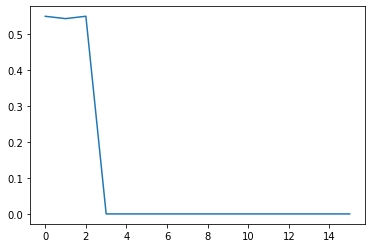

Epoch 1/5


Metrics: loss: 2.7931 - accuracy: 0.2013 - val_loss: 2.0869 - val_accuracy: 0.4400           
Epoch 2/5


Metrics: loss: 1.8968 - accuracy: 0.4733 - val_loss: 1.8129 - val_accuracy: 0.4967           
Epoch 3/5


Metrics: loss: 1.6443 - accuracy: 0.5266 - val_loss: 1.6586 - val_accuracy: 0.5017           
Epoch 4/5


Metrics: loss: 1.5138 - accuracy: 0.5574 - val_loss: 1.4714 - val_accuracy: 0.5283           
Epoch 5/5


Metrics: loss: 1.4682 - accuracy: 0.5730 - val_loss: 1.3671 - val_accuracy: 0.5483           


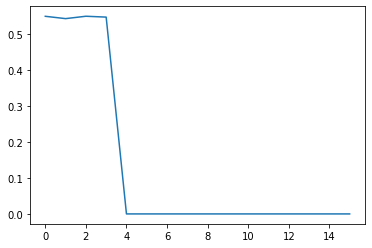

Epoch 1/5


Metrics: loss: 3.1253 - accuracy: 0.1843 - val_loss: 2.4310 - val_accuracy: 0.4068           
Epoch 2/5


Metrics: loss: 2.2007 - accuracy: 0.4221 - val_loss: 1.9436 - val_accuracy: 0.5297           
Epoch 3/5


Metrics: loss: 1.8538 - accuracy: 0.5007 - val_loss: 1.8163 - val_accuracy: 0.5254           
Epoch 4/5


Metrics: loss: 1.7290 - accuracy: 0.5300 - val_loss: 1.6888 - val_accuracy: 0.5487           
Epoch 5/5


Metrics: loss: 1.5800 - accuracy: 0.5485 - val_loss: 1.4379 - val_accuracy: 0.5657           
Metrics: loss: 1.5796 - accuracy: 0.5485           

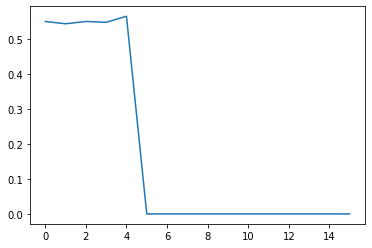

Epoch 1/5


Metrics: loss: 3.6171 - accuracy: 0.1320 - val_loss: 3.2467 - val_accuracy: 0.2806           
Epoch 2/5


Metrics: loss: 2.9503 - accuracy: 0.3213 - val_loss: 2.6354 - val_accuracy: 0.3444           
Epoch 3/5


Metrics: loss: 2.3564 - accuracy: 0.4312 - val_loss: 1.9724 - val_accuracy: 0.4847           
Epoch 4/5


Metrics: loss: 2.1058 - accuracy: 0.4948 - val_loss: 1.8804 - val_accuracy: 0.4821           
Epoch 5/5


Metrics: loss: 1.8983 - accuracy: 0.5098 - val_loss: 1.7232 - val_accuracy: 0.5255           


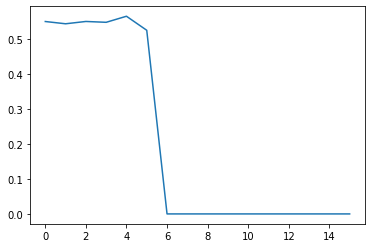

Epoch 1/5


Metrics: loss: 3.3176 - accuracy: 0.1499 - val_loss: 2.8828 - val_accuracy: 0.2896           
Epoch 2/5


Metrics: loss: 2.3400 - accuracy: 0.3860 - val_loss: 2.1492 - val_accuracy: 0.4451           
Epoch 3/5


Metrics: loss: 1.9074 - accuracy: 0.4900 - val_loss: 1.8632 - val_accuracy: 0.4543           
Epoch 4/5


Metrics: loss: 1.7434 - accuracy: 0.5305 - val_loss: 1.6951 - val_accuracy: 0.5396           
Epoch 5/5


Metrics: loss: 1.5615 - accuracy: 0.5652 - val_loss: 1.6833 - val_accuracy: 0.5091           


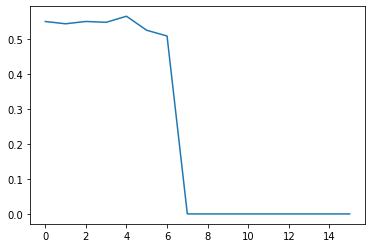

Epoch 1/5


Metrics: loss: 3.3576 - accuracy: 0.1501 - val_loss: 2.8867 - val_accuracy: 0.2535           
Epoch 2/5


Metrics: loss: 2.6988 - accuracy: 0.3373 - val_loss: 2.4684 - val_accuracy: 0.3542           
Epoch 3/5


Metrics: loss: 2.2722 - accuracy: 0.4304 - val_loss: 2.1330 - val_accuracy: 0.4444           
Epoch 4/5


Metrics: loss: 2.0283 - accuracy: 0.4684 - val_loss: 2.0599 - val_accuracy: 0.4549           
Epoch 5/5


Metrics: loss: 1.8429 - accuracy: 0.5136 - val_loss: 1.8837 - val_accuracy: 0.5208           


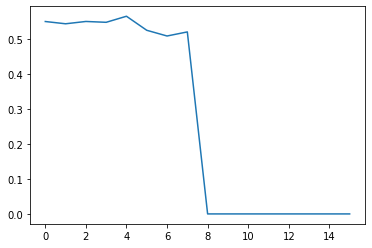

Epoch 1/5


Metrics: loss: 3.4253 - accuracy: 0.1374 - val_loss: 3.1928 - val_accuracy: 0.2016           
Epoch 2/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 1.7587 - accuracy: 0.5305 - val_loss: 1.7238 - val_accuracy: 0.5363           


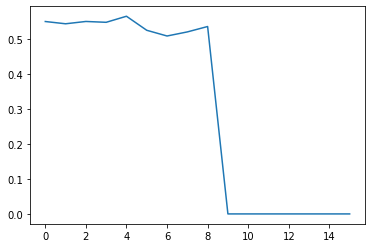

Epoch 1/5


Metrics: loss: 4.1436 - accuracy: 0.0403               

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 3.3773 - accuracy: 0.1344 - val_loss: 2.8369 - val_accuracy: 0.3348           
Epoch 2/5


Metrics: loss: 2.7418 - accuracy: 0.3037           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.5638 - accuracy: 0.3298 - val_loss: 2.2348 - val_accuracy: 0.4598           
Epoch 3/5


Metrics: loss: 2.1877 - accuracy: 0.4463           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 1.7243 - accuracy: 0.5248 - val_loss: 1.6298 - val_accuracy: 0.5580           


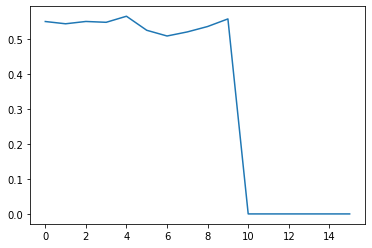

Epoch 1/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 3.4725 - accuracy: 0.1314 - val_loss: 2.9371 - val_accuracy: 0.3050           
Epoch 2/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.3534 - accuracy: 0.4134           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.1274 - accuracy: 0.4691 - val_loss: 2.0761 - val_accuracy: 0.4050           
Epoch 5/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.8877 - accuracy: 0.2804 - val_loss: 2.6646 - val_accuracy: 0.3587           
Epoch 3/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 1.9735 - accuracy: 0.4957 - val_loss: 1.9203 - val_accuracy: 0.4783           


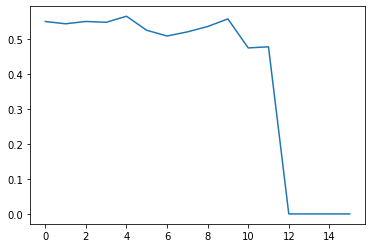

Epoch 1/5


Metrics: loss: 3.8984 - accuracy: 0.0796               

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.4457 - accuracy: 0.3885 - val_loss: 2.4534 - val_accuracy: 0.3810           
Epoch 4/5


Metrics: loss: 2.2144 - accuracy: 0.4433           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 3.5165 - accuracy: 0.1280 - val_loss: 3.2223 - val_accuracy: 0.2303           
Epoch 2/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.4937 - accuracy: 0.3787 - val_loss: 2.3914 - val_accuracy: 0.4013           
Epoch 4/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.0222 - accuracy: 0.4747 - val_loss: 2.1664 - val_accuracy: 0.4934           


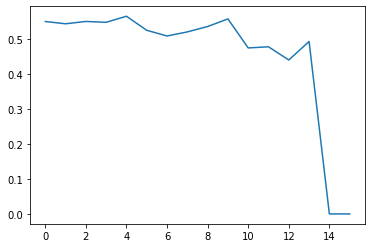

Epoch 1/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.9022 - accuracy: 0.2744 - val_loss: 2.6222 - val_accuracy: 0.3897           
Epoch 3/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.5887 - accuracy: 0.3670 - val_loss: 2.3131 - val_accuracy: 0.4191           
Epoch 4/5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.2496 - accuracy: 0.4591 - val_loss: 1.9816 - val_accuracy: 0.5368           


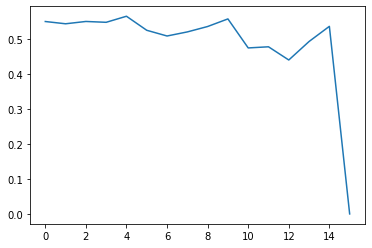

Epoch 1/5


Metrics: loss: 3.8765 - accuracy: 0.0713               

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 3.1509 - accuracy: 0.2583 - val_loss: 2.8871 - val_accuracy: 0.2969           
Epoch 3/5


Metrics: loss: 2.8966 - accuracy: 0.3176           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metrics: loss: 2.5849 - accuracy: 0.3927 - val_loss: 2.5510 - val_accuracy: 0.3750           
Epoch 5/5


Metrics: loss: 2.3043 - accuracy: 0.4270               

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
val_accs = np.zeros(len(range(2,33,2)))
val_accs[0]=0.5506
val_accs[1]=0.5441
test_num = 2
for d in range(6,33,2):
    depth = d
    model,name = build_model(None,input_shape=(80,80,1))
    data_gen = DataGenerator(filepath,data_amount=DATA_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=OFFSET_AMOUNT)
    validation_gen = DataGenerator(filepath,data_amount=VALIDATION_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=DATA_AMOUNT+OFFSET_AMOUNT)
    history = model.fit_generator(generator=data_gen,
                    validation_data=validation_gen,
                    epochs=5,
                    verbose=0,
                    use_multiprocessing=True,
                    workers=10,
                    callbacks=[Logger.JupyterProgbarLogger(count_mode='steps'),
                              keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6,verbose=1, mode='auto',restore_best_weights=True)]
                   )
    val_accs[test_num]=(history.history['val_accuracy'][::-1])[0]
    test_num+=1
    plt.plot(val_accs)
    plt.show()

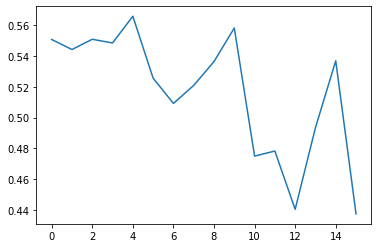

In [40]:
plt.plot(val_accs)
plt.show()

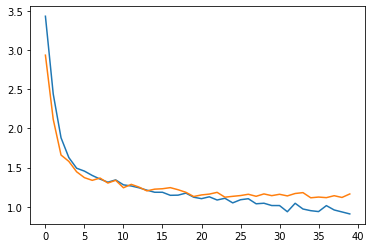

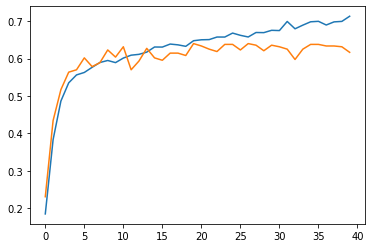

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [10]:
filename = "model-"+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')+".h5"
model.save(filename)
print("Model saved to ",filename)

Model saved to  model-2019-07-31-10:58:45.h5


In [ ]:
def accuracy(predictions, answers, top_n=5):
    accs = np.zeros(len(answers))
    predicts = np.zeros(len(test_labels))
    for i in range(0,len(answers)):
        j = len(predictions[i])-1
        for k in range(0,top_n):
            if predictions[i][j-k]==answers[i]:
                accs[i]=1
                predicts[i]=predictions[i][j-k]
    return np.mean(accs), predicts

In [ ]:
with h5py.File(filepath,'r') as f:
    if depth > 1:
        test_data=np.zeros((1000,depth,80,80))
        test_labels=np.zeros(1000)
        i=0
        #Starting index for batch samples
        index = 0
        while i < 1000:
            #Loop forward to add to the frame sequence
            cur_amount = 0
            while cur_amount < depth:
                label = f["/labels"][index]
                if label >= 0:
                    test_data[i][cur_amount]=f["/frames/raw"][index]
                    test_labels[i]=f["/labels"][index]
                    index+=1
                    cur_amount+=1
                else:
                    index+=1
            i+=1
        test_data = test_data[...,None]
    else:
        test_data=np.zeros((1000,80,80))
        test_labels=np.zeros(1000)
        i=0
        #Starting index for batch samples
        index = 0
        while i < 1000:
            #Loop forward to add to the frame sequence
            label = f["/labels"][index]
            if label >= 0:
                test_data[i]=f["/frames/raw"][index]
                test_labels[i]=f["/labels"][index]
                index+=1
                i+=1
            else:
                index+=1
        test_data = test_data[...,None]

In [ ]:
p = model.predict(test_data)
for i in range(0,len(p)):
    p[i]=np.argsort(p[i])

In [ ]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
mean, predicts = accuracy(p,test_labels,top_n=1)
print(mean)
freqs = np.unique(test_labels,return_counts=True)[1]
f1 = metrics.f1_score(test_labels,predicts,average=None)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(freqs,f1)
plt.xlim(0,100)
plt.ylim(0,1)
np.set_printoptions(threshold=np.inf)
conf_mat=metrics.confusion_matrix(test_labels,[x[(len(x)-1)] for x in p])
conf_mat=conf_mat / conf_mat.astype(np.float).sum(axis=1,keepdims=True)
#print(np.array2string(conf_mat, max_line_width=np.inf))

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(conf_mat)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [ ]:
filename = "model-"+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')+".h5"
model.save(filename)
print("Model saved to ",filename)

In [ ]:
model_benchmarks = np.load("benchmarks.npy")
model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
np.save("benchmarks.npy",model_benchmarks)
print(model_benchmarks)

In [ ]:
plt.plot(predicts)
plt.plot(test_labels)
#with h5py.File("images_raw_doric_round1.h5",'r') as f:
#    lbls = f["/labels"][:2000000:depth]
#plt.plot(lbls)
plt.xlim(800,830)
plt.show()

In [ ]:
with h5py.File(filepath,'r') as f:
    l = len(f["/labels"])
    print(int(15*l/32))
    print(len(f["/labels"][int(15*l/32):int(17*l/32)]))

In [ ]:
pl = model.predict(data_gen.__getitem__(518)[0])
plc = np.zeros(len(pl))
for i in range (0,len(pl)):
    plc[i]=np.argmax(pl[i])
plt.plot(plc)
plt.plot(data_gen.__getitem__(518)[1])
plt.show()